In [11]:
%load_ext tensorboard

import tensorflow as tf
import keras
from keras import layers
import yaml, datetime
from tensorboard.plugins.hparams import api as hp

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
batch_size = 32
img_height = 256
img_width = 256

with open('config.yml', 'r') as file:
    paths = yaml.safe_load(file)

data_dir = paths['paths']['categories_path']

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 4583 files belonging to 7 classes.
Using 3667 files for training.
Found 4583 files belonging to 7 classes.
Using 916 files for validation.


2024-01-07 02:34:45.681114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3667]
	 [[{{node Placeholder/_0}}]]
2024-01-07 02:34:45.683202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3667]
	 [[{{node Placeholder/_4}}]]


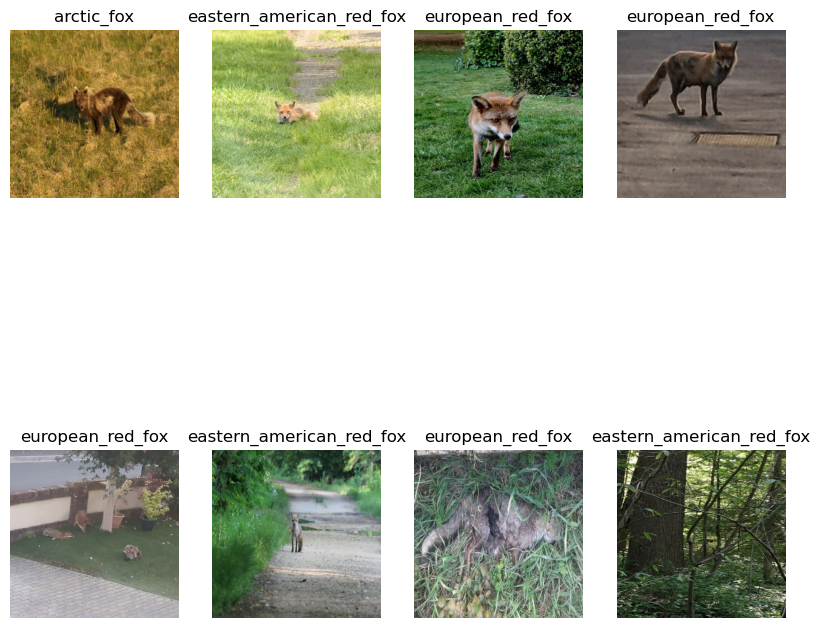

In [14]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [15]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)

input = keras.Input(shape=(256, 256, 3))
x = data_augmentation(input)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu')(x)
x = layers.Flatten()(x)
output = layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs=input, outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                           

In [16]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_ds, 
                    epochs=50, 
                    validation_data=val_ds, 
                    callbacks=[tensorboard_callback])

Epoch 1/50


2024-01-07 02:34:47.990778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3667]
	 [[{{node Placeholder/_0}}]]
2024-01-07 02:34:47.991465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3667]
	 [[{{node Placeholder/_0}}]]
2024-01-07 02:34:50.249432: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 358.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01

 43/115 [==========>...................] - ETA: 5s - loss: 1.8102 - accuracy: 0.2725

2024-01-07 02:34:57.615660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - ETA: 0s - loss: 1.7595 - accuracy: 0.2880

2024-01-07 02:35:04.393448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [916]
	 [[{{node Placeholder/_0}}]]
2024-01-07 02:35:04.394458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [916]
	 [[{{node Placeholder/_4}}]]


115/115 [==============================] - 19s 105ms/step - loss: 1.7595 - accuracy: 0.2880 - val_loss: 1.7700 - val_accuracy: 0.2760
Epoch 2/50
 42/115 [=========>....................] - ETA: 5s - loss: 1.7017 - accuracy: 0.3296

2024-01-07 02:35:10.171170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 12s 99ms/step - loss: 1.6837 - accuracy: 0.3354 - val_loss: 1.8144 - val_accuracy: 0.3539
Epoch 3/50
 42/115 [=========>....................] - ETA: 6s - loss: 1.6412 - accuracy: 0.3616

2024-01-07 02:35:22.341312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 12s 102ms/step - loss: 1.6358 - accuracy: 0.3493 - val_loss: 1.6996 - val_accuracy: 0.3377
Epoch 4/50
 42/115 [=========>....................] - ETA: 5s - loss: 1.6099 - accuracy: 0.3601

2024-01-07 02:35:34.379673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 12s 102ms/step - loss: 1.5962 - accuracy: 0.3698 - val_loss: 1.7017 - val_accuracy: 0.3377
Epoch 5/50
 42/115 [=========>....................] - ETA: 6s - loss: 1.5681 - accuracy: 0.3638

2024-01-07 02:35:46.561851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 111ms/step - loss: 1.5728 - accuracy: 0.3711 - val_loss: 1.6558 - val_accuracy: 0.3766
Epoch 6/50
 42/115 [=========>....................] - ETA: 6s - loss: 1.5532 - accuracy: 0.3824

2024-01-07 02:36:00.121438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 108ms/step - loss: 1.5387 - accuracy: 0.3938 - val_loss: 1.6290 - val_accuracy: 0.3636
Epoch 7/50
 43/115 [==========>...................] - ETA: 6s - loss: 1.5544 - accuracy: 0.3779

2024-01-07 02:36:13.013939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 108ms/step - loss: 1.5450 - accuracy: 0.3782 - val_loss: 1.7818 - val_accuracy: 0.3312
Epoch 8/50
 41/115 [=========>....................] - ETA: 6s - loss: 1.5076 - accuracy: 0.4177

2024-01-07 02:36:26.090654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 115ms/step - loss: 1.5060 - accuracy: 0.4134 - val_loss: 1.6199 - val_accuracy: 0.3636
Epoch 9/50
 41/115 [=========>....................] - ETA: 6s - loss: 1.5068 - accuracy: 0.3971

2024-01-07 02:36:40.003504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 117ms/step - loss: 1.4897 - accuracy: 0.4161 - val_loss: 1.6649 - val_accuracy: 0.3766
Epoch 10/50
 42/115 [=========>....................] - ETA: 6s - loss: 1.4588 - accuracy: 0.4234

2024-01-07 02:36:54.046697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 117ms/step - loss: 1.4645 - accuracy: 0.4279 - val_loss: 1.5325 - val_accuracy: 0.4156
Epoch 11/50
 42/115 [=========>....................] - ETA: 6s - loss: 1.4317 - accuracy: 0.4397

2024-01-07 02:37:08.758952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 117ms/step - loss: 1.4331 - accuracy: 0.4421 - val_loss: 1.5580 - val_accuracy: 0.4091
Epoch 12/50
 41/115 [=========>....................] - ETA: 6s - loss: 1.4408 - accuracy: 0.4192

2024-01-07 02:37:22.600603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 118ms/step - loss: 1.4252 - accuracy: 0.4369 - val_loss: 1.5007 - val_accuracy: 0.4058
Epoch 13/50
 41/115 [=========>....................] - ETA: 6s - loss: 1.3940 - accuracy: 0.4444

2024-01-07 02:37:36.935359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 119ms/step - loss: 1.3781 - accuracy: 0.4622 - val_loss: 1.5326 - val_accuracy: 0.4058
Epoch 14/50
 41/115 [=========>....................] - ETA: 7s - loss: 1.3658 - accuracy: 0.4520

2024-01-07 02:37:51.547982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 121ms/step - loss: 1.3612 - accuracy: 0.4620 - val_loss: 1.4561 - val_accuracy: 0.4318
Epoch 15/50
 42/115 [=========>....................] - ETA: 6s - loss: 1.3860 - accuracy: 0.4509

2024-01-07 02:38:06.127236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 121ms/step - loss: 1.3546 - accuracy: 0.4650 - val_loss: 1.4850 - val_accuracy: 0.4253
Epoch 16/50
 41/115 [=========>....................] - ETA: 7s - loss: 1.3443 - accuracy: 0.4703

2024-01-07 02:38:27.275742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 121ms/step - loss: 1.3117 - accuracy: 0.4865 - val_loss: 1.4258 - val_accuracy: 0.4221
Epoch 17/50
 42/115 [=========>....................] - ETA: 7s - loss: 1.3143 - accuracy: 0.4896

2024-01-07 02:38:42.169567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 126ms/step - loss: 1.3034 - accuracy: 0.4903 - val_loss: 1.4115 - val_accuracy: 0.4545
Epoch 18/50
 42/115 [=========>....................] - ETA: 7s - loss: 1.2835 - accuracy: 0.4926

2024-01-07 02:38:57.564391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 16s 129ms/step - loss: 1.2656 - accuracy: 0.5059 - val_loss: 1.4751 - val_accuracy: 0.3734
Epoch 19/50
 43/115 [==========>...................] - ETA: 8s - loss: 1.2624 - accuracy: 0.5073

2024-01-07 02:39:13.956384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 17s 135ms/step - loss: 1.2271 - accuracy: 0.5244 - val_loss: 1.5030 - val_accuracy: 0.4123
Epoch 20/50
 42/115 [=========>....................] - ETA: 7s - loss: 1.2509 - accuracy: 0.5037

2024-01-07 02:39:29.327599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 126ms/step - loss: 1.2097 - accuracy: 0.5225 - val_loss: 1.4497 - val_accuracy: 0.4513
Epoch 21/50
 43/115 [==========>...................] - ETA: 7s - loss: 1.1829 - accuracy: 0.5320

2024-01-07 02:39:45.113207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 16s 129ms/step - loss: 1.1979 - accuracy: 0.5334 - val_loss: 1.4539 - val_accuracy: 0.4156
Epoch 22/50
 43/115 [==========>...................] - ETA: 6s - loss: 1.1998 - accuracy: 0.5342

2024-01-07 02:39:59.995243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 122ms/step - loss: 1.1548 - accuracy: 0.5536 - val_loss: 1.5383 - val_accuracy: 0.4675
Epoch 23/50
 43/115 [==========>...................] - ETA: 6s - loss: 1.1389 - accuracy: 0.5603

2024-01-07 02:40:14.627504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 125ms/step - loss: 1.1241 - accuracy: 0.5634 - val_loss: 1.6780 - val_accuracy: 0.4481
Epoch 24/50
 44/115 [==========>...................] - ETA: 8s - loss: 1.1350 - accuracy: 0.5533

2024-01-07 02:40:31.210806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 17s 143ms/step - loss: 1.1036 - accuracy: 0.5729 - val_loss: 1.4075 - val_accuracy: 0.4805
Epoch 25/50
 43/115 [==========>...................] - ETA: 7s - loss: 1.1130 - accuracy: 0.5516

2024-01-07 02:40:46.988806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 16s 135ms/step - loss: 1.0761 - accuracy: 0.5749 - val_loss: 1.6290 - val_accuracy: 0.4221
Epoch 26/50
 44/115 [==========>...................] - ETA: 7s - loss: 1.1113 - accuracy: 0.5746

2024-01-07 02:41:03.596578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 17s 138ms/step - loss: 1.0561 - accuracy: 0.6002 - val_loss: 1.5154 - val_accuracy: 0.4481
Epoch 27/50
 43/115 [==========>...................] - ETA: 7s - loss: 1.0299 - accuracy: 0.6134

2024-01-07 02:41:19.968508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 123ms/step - loss: 1.0144 - accuracy: 0.6212 - val_loss: 1.6687 - val_accuracy: 0.4351
Epoch 28/50
 42/115 [=========>....................] - ETA: 7s - loss: 1.0173 - accuracy: 0.6057

2024-01-07 02:41:34.507235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 16s 131ms/step - loss: 1.0254 - accuracy: 0.6109 - val_loss: 1.5905 - val_accuracy: 0.4286
Epoch 29/50
 43/115 [==========>...................] - ETA: 6s - loss: 0.9764 - accuracy: 0.6163

2024-01-07 02:41:50.556157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 125ms/step - loss: 0.9577 - accuracy: 0.6316 - val_loss: 1.6384 - val_accuracy: 0.4578
Epoch 30/50
 42/115 [=========>....................] - ETA: 7s - loss: 0.9453 - accuracy: 0.6280

2024-01-07 02:42:05.992351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 125ms/step - loss: 0.9282 - accuracy: 0.6493 - val_loss: 1.5486 - val_accuracy: 0.4740
Epoch 31/50
 41/115 [=========>....................] - ETA: 6s - loss: 0.9342 - accuracy: 0.6540

2024-01-07 02:42:25.414071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 110ms/step - loss: 0.8955 - accuracy: 0.6657 - val_loss: 1.4619 - val_accuracy: 0.4773
Epoch 32/50
 43/115 [==========>...................] - ETA: 6s - loss: 0.9141 - accuracy: 0.6453

2024-01-07 02:42:38.869158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 113ms/step - loss: 0.8722 - accuracy: 0.6621 - val_loss: 1.7247 - val_accuracy: 0.4221
Epoch 33/50
 42/115 [=========>....................] - ETA: 7s - loss: 0.8520 - accuracy: 0.6808

2024-01-07 02:42:53.314665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 121ms/step - loss: 0.8583 - accuracy: 0.6831 - val_loss: 1.8438 - val_accuracy: 0.4416
Epoch 34/50
 42/115 [=========>....................] - ETA: 6s - loss: 0.9057 - accuracy: 0.6525

2024-01-07 02:43:07.219537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 127ms/step - loss: 0.8602 - accuracy: 0.6755 - val_loss: 1.6380 - val_accuracy: 0.4610
Epoch 35/50
 41/115 [=========>....................] - ETA: 7s - loss: 0.8220 - accuracy: 0.6936

2024-01-07 02:43:22.876632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 19s 156ms/step - loss: 0.7939 - accuracy: 0.6957 - val_loss: 1.6486 - val_accuracy: 0.4773
Epoch 36/50
 43/115 [==========>...................] - ETA: 6s - loss: 0.7722 - accuracy: 0.7238

2024-01-07 02:43:41.235168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 15s 129ms/step - loss: 0.7632 - accuracy: 0.7150 - val_loss: 1.6876 - val_accuracy: 0.4935
Epoch 37/50
 42/115 [=========>....................] - ETA: 7s - loss: 0.7722 - accuracy: 0.7121

2024-01-07 02:43:57.047094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 17s 142ms/step - loss: 0.7495 - accuracy: 0.7188 - val_loss: 1.7542 - val_accuracy: 0.4773
Epoch 38/50
 43/115 [==========>...................] - ETA: 7s - loss: 0.7340 - accuracy: 0.7267

2024-01-07 02:44:14.345399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 16s 134ms/step - loss: 0.7127 - accuracy: 0.7328 - val_loss: 2.0019 - val_accuracy: 0.4481
Epoch 39/50
 44/115 [==========>...................] - ETA: 8s - loss: 0.6952 - accuracy: 0.7422

2024-01-07 02:44:32.209385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 16s 127ms/step - loss: 0.7072 - accuracy: 0.7415 - val_loss: 1.8525 - val_accuracy: 0.4481
Epoch 40/50
 42/115 [=========>....................] - ETA: 5s - loss: 0.6626 - accuracy: 0.7515

2024-01-07 02:44:45.228250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 106ms/step - loss: 0.6330 - accuracy: 0.7657 - val_loss: 1.6945 - val_accuracy: 0.4870
Epoch 41/50
 42/115 [=========>....................] - ETA: 6s - loss: 0.6305 - accuracy: 0.7783

2024-01-07 02:44:57.990351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 107ms/step - loss: 0.6387 - accuracy: 0.7709 - val_loss: 2.1864 - val_accuracy: 0.4643
Epoch 42/50
 42/115 [=========>....................] - ETA: 6s - loss: 0.6868 - accuracy: 0.7426

2024-01-07 02:45:10.783862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 12s 103ms/step - loss: 0.6167 - accuracy: 0.7745 - val_loss: 2.3187 - val_accuracy: 0.4448
Epoch 43/50
 42/115 [=========>....................] - ETA: 6s - loss: 0.6150 - accuracy: 0.7664

2024-01-07 02:45:23.010295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 12s 104ms/step - loss: 0.5962 - accuracy: 0.7753 - val_loss: 2.0490 - val_accuracy: 0.4481
Epoch 44/50
 42/115 [=========>....................] - ETA: 6s - loss: 0.6512 - accuracy: 0.7485

2024-01-07 02:45:36.150814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 106ms/step - loss: 0.6057 - accuracy: 0.7717 - val_loss: 2.0095 - val_accuracy: 0.4675
Epoch 45/50
 41/115 [=========>....................] - ETA: 6s - loss: 0.5208 - accuracy: 0.8072

2024-01-07 02:45:48.373157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 106ms/step - loss: 0.5371 - accuracy: 0.8020 - val_loss: 2.2220 - val_accuracy: 0.4578
Epoch 46/50
 41/115 [=========>....................] - ETA: 6s - loss: 0.5596 - accuracy: 0.7767

2024-01-07 02:46:01.031003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 13s 106ms/step - loss: 0.5330 - accuracy: 0.7955 - val_loss: 2.0501 - val_accuracy: 0.4610
Epoch 47/50
 41/115 [=========>....................] - ETA: 6s - loss: 0.5932 - accuracy: 0.7706

2024-01-07 02:46:13.765109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 12s 103ms/step - loss: 0.5310 - accuracy: 0.8031 - val_loss: 2.4124 - val_accuracy: 0.4740
Epoch 48/50
 42/115 [=========>....................] - ETA: 6s - loss: 0.5048 - accuracy: 0.8199

2024-01-07 02:46:26.454630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 12s 104ms/step - loss: 0.4781 - accuracy: 0.8309 - val_loss: 2.2069 - val_accuracy: 0.4545
Epoch 49/50
 42/115 [=========>....................] - ETA: 5s - loss: 0.5548 - accuracy: 0.8013

2024-01-07 02:46:38.507937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 12s 102ms/step - loss: 0.4947 - accuracy: 0.8217 - val_loss: 2.3535 - val_accuracy: 0.4968
Epoch 50/50
 42/115 [=========>....................] - ETA: 7s - loss: 0.4619 - accuracy: 0.8333

2024-01-07 02:46:51.604473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


115/115 [==============================] - 14s 116ms/step - loss: 0.4500 - accuracy: 0.8367 - val_loss: 2.3111 - val_accuracy: 0.4610


In [8]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-01-07 02:33:07.463830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

2024-01-07 02:47:05.280639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [916]
	 [[{{node Placeholder/_0}}]]
2024-01-07 02:47:05.282800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [916]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 210ms/step


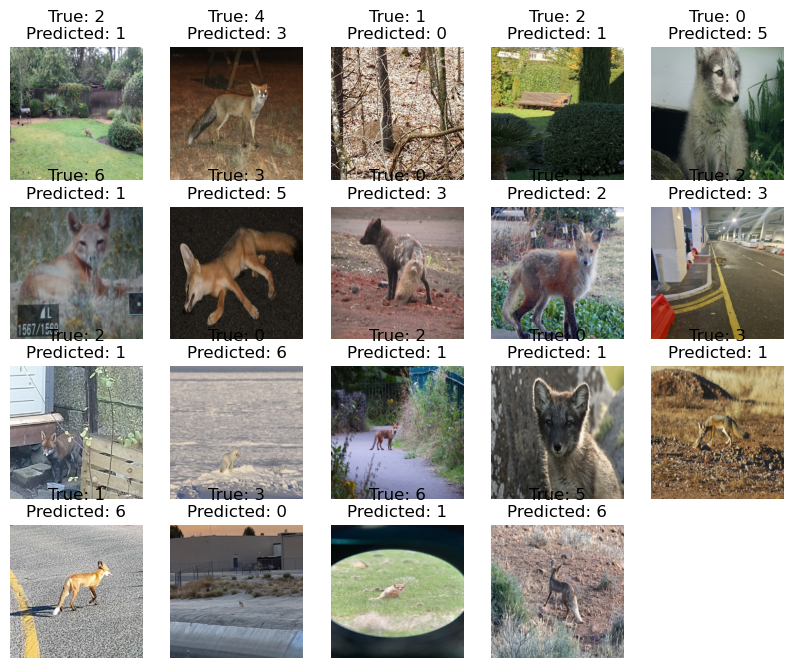

In [17]:
for images, labels in val_ds.take(1):
    labels = labels.numpy()
    predictions = [tf.argmax(i).numpy() for i in model.predict(images)]
    misclassified_indices = [i for i in range(len(predictions)) if predictions[i] != labels[i]]
    misclassified_images = [images[i] for i in misclassified_indices]

    plt.figure(figsize=(10, 10))
    for i in range(len(misclassified_images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(misclassified_images[i].numpy().astype("uint8"))
        plt.title(f"True: {labels[misclassified_indices[i]]}\nPredicted: {predictions[misclassified_indices[i]]}")
        plt.axis('off')

    plt.show()

In [18]:
model.evaluate(test_ds)

2024-01-07 02:47:29.642719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [916]
	 [[{{node Placeholder/_0}}]]
2024-01-07 02:47:29.643856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [916]
	 [[{{node Placeholder/_4}}]]


19/19 [==============================] - 1s 37ms/step - loss: 2.2942 - accuracy: 0.5000


[2.2942473888397217, 0.5]